In [1]:
# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import re
import glob
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import dask
# dask.set_options(get=dask.threaded.get)
from dask.distributed import Client


In [4]:
# FYI the models are
models = ['CESM2','CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2', 
          'GFDL-ESM4', 'MIROC-ES2L', 'MIROC6','CanESM5','CNRM-CM6-1',
          'CNRM-ESM2-1','EC-Earth3','EC-Earth3-Veg','IPSL-CM6A-LR','GFDL-CM4',
          'NorESM2-LM','SAM0-UNICON','UKESM1-0-LL','HadGEM3-GC31-LL',
          'CAMS-CSM1-0','MRI-ESM2-0','NESM3']

File_object = open("datafiles","r")
thefiles=File_object.readlines()

for (im,fullfilename) in enumerate(thefiles):
    #print(fullfilename)
    datafile=fullfilename.split('.nc')[0]+'.nc'  # first get rid of the /n at end
    stuff=datafile.split('/')
    model=stuff[7]
    
#    if model in ['NESM3']:
#        print('Model ', model,' has no areacello so cannot process :<')
#        continue
 
    if model in ['EC-Earth3','EC-Earth3-Veg']:
        print('Skipping Model ', model,' because it is probably already done but concatinated')
        print('  If not, then remove this if ')
        continue

    parts=stuff[-1]
    outfile='../SIA_by_regions_RAW/regions_'+parts

    if os.path.isfile(outfile):
        print('Skipping file already processed: ', outfile)
        continue

    print(outfile)

    regionfile='regionmask_surfaceareacell_'+model+'.nc'
    #print(regionfile)
    model_regions = xr.open_mfdataset(regionfile)
    ds = xr.open_mfdataset(datafile)
    #print(model_regions)
    #print('the model is ',model)

    # limiting the latitude range to high northern latitudes helps make these run much faster
    if model in ['NESM3','CESM2','CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2']:
        da = ds.siconc.sel(nj=slice(281,384))  # charming, the indices are different in CESM2 for ocean and ice
        model_regions = model_regions.sel(nlat=slice(281,384))
        model_regions=model_regions.rename({'nlat':'nj','nlon':'ni'})
    elif model in ['MRI-ESM2-0','GFDL-ESM4', 'MIROC-ES2L', 'MIROC6','GFDL-CM4']:
        da = ds.siconc.sel(y=slice(45,190))  
        model_regions = model_regions.sel(y=slice(45,190))
    elif model in ['IPSL-CM6A-LR','CNRM-CM6-1','CNRM-ESM2-1']:
        da = ds.siconc.sel(y=slice(200,500))  
        model_regions = model_regions.sel(y=slice(200,500))        
    elif model in ['CanESM5','EC-Earth3','EC-Earth3-Veg']:
        da = ds.siconc.sel(j=slice(200,300))  
        model_regions = model_regions.sel(j=slice(200,300))
    elif model in ['CAMS-CSM1-0']:
        da = ds.siconc.sel(j=slice(140,300))  
        model_regions = model_regions.sel(j=slice(140,300))
    elif model in ['NorESM2-LM','SAM0-UNICON']:
        da = ds.siconc.sel(j=slice(280,500)) 
        model_regions = model_regions.sel(j=slice(280,500))
    elif model in ['UKESM1-0-LL','HadGEM3-GC31-LL']:
        da = ds.siconc.sel(j=slice(240,400))  
        model_regions = model_regions.sel(j=slice(240,400))
        
    model_regions.load()
    dawt = da*model_regions.areacello*1e-6   # area weighted in sq-km 
    thedims=dawt.dims
    horizdims = thedims[1:3]
    print(horizdims)

    model_areas=[]
    for nreg in np.arange(0,21):  #regions 0 to 20 are subregions in the mask
        model_area=dawt.where(model_regions.region_mask.values==nreg).sum(dim=horizdims)
        model_area['nregions']=nreg
        model_area['region_names']=model_regions.region_names.isel(nregions=nreg).values
        model_areas.append(model_area)

    # Calc panArctic area too 
    nreg=21
    model_area=dawt.sum(dim=horizdims)
    model_area['nregions']=nreg
    model_area['region_names']='panArctic'
    model_areas.append(model_area)

    model_areas=xr.concat(model_areas, dim='nregions')
    model_areas=model_areas.transpose()
    ds=model_areas.to_dataset('Region_Areas')
    tmp=np.append(model_regions.region_area.values,255e6)
    ds['Max_Possible_Region_Area'] = xr.DataArray(tmp, dims='nregions')
    tmp=np.append(model_regions.region_area_relative2NSIDC.values,1)
    ds['Max_Possible_Relative2NSIDC'] = xr.DataArray(tmp, dims='nregions')
    ds.to_netcdf(outfile)

    

../SIA_by_regions_RAW/regions_siconc_SImon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
('j', 'i')
../SIA_by_regions_RAW/regions_siconc_SImon_CAMS-CSM1-0_historical_r2i1p1f1_gn_185001-201412.nc
('j', 'i')
Skipping file already processed:  ../SIA_by_regions_RAW/regions_siconc_SImon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc
Skipping file already processed:  ../SIA_by_regions_RAW/regions_siconc_SImon_CanESM5_historical_r10i1p2f1_gn_185001-201412.nc
Skipping file already processed:  ../SIA_by_regions_RAW/regions_siconc_SImon_CanESM5_historical_r11i1p1f1_gn_185001-201412.nc
Skipping file already processed:  ../SIA_by_regions_RAW/regions_siconc_SImon_CanESM5_historical_r11i1p2f1_gn_185001-201412.nc
Skipping file already processed:  ../SIA_by_regions_RAW/regions_siconc_SImon_CanESM5_historical_r12i1p1f1_gn_185001-201412.nc
Skipping file already processed:  ../SIA_by_regions_RAW/regions_siconc_SImon_CanESM5_historical_r12i1p2f1_gn_185001-201412.nc
Skipping file already processed:

Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3  because it is probably already done but concatinated
  If not, then remove this if 
S

Skipping Model  EC-Earth3-Veg  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3-Veg  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3-Veg  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3-Veg  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3-Veg  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3-Veg  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3-Veg  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3-Veg  because it is probably already done but concatinated
  If not, then remove this if 
Skipping Model  EC-Earth3-Veg  because it is probably already done but concatina

# Plots for Sanity Check

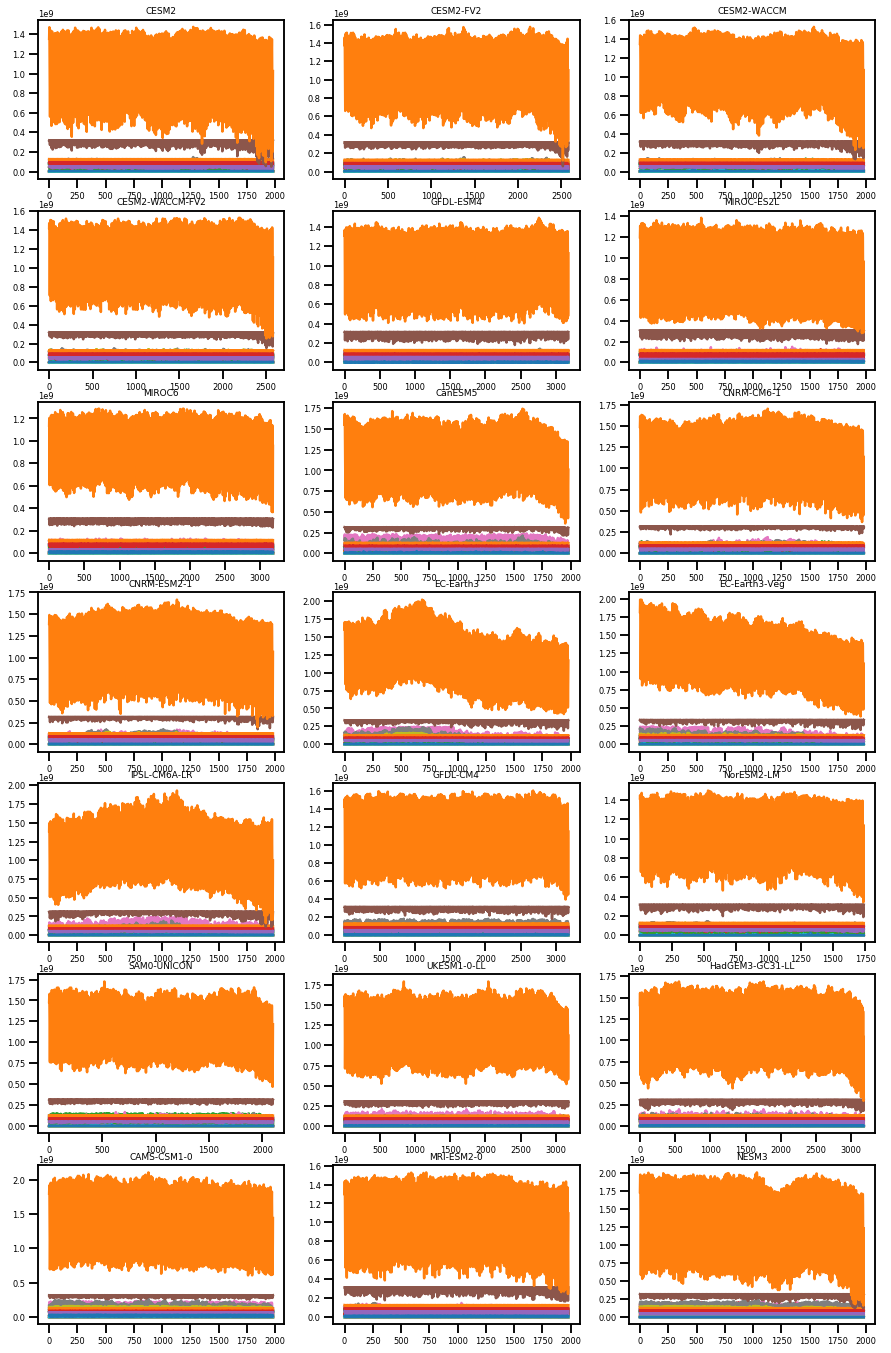

In [5]:
models = ['CESM2','CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2', 
          'GFDL-ESM4', 'MIROC-ES2L', 'MIROC6','CanESM5','CNRM-CM6-1',
          'CNRM-ESM2-1','EC-Earth3','EC-Earth3-Veg','IPSL-CM6A-LR','GFDL-CM4',
          'NorESM2-LM','SAM0-UNICON','UKESM1-0-LL','HadGEM3-GC31-LL',
          'CAMS-CSM1-0','MRI-ESM2-0','NESM3']

f, ax = plt.subplots(nrows=7,ncols=3)
f.set_size_inches(15,24)
ax = ax.reshape(-1)
sns.set_context("talk", font_scale=0.5, rc={"lines.linewidth": 2.5})

for (im,model) in enumerate(models):
    infile = glob.glob('../SIA_by_regions/regions_siconc_SImon_'+model+'_historical_*.nc')
    ds=xr.open_mfdataset(infile[0])
    ax[im].plot(ds.Region_Areas.values)
    ax[im].set_title(model)
    
# MIROC models are rather low but all else looks good

# Plot one region, 12 = Beaufort Sea, for Sanity Check

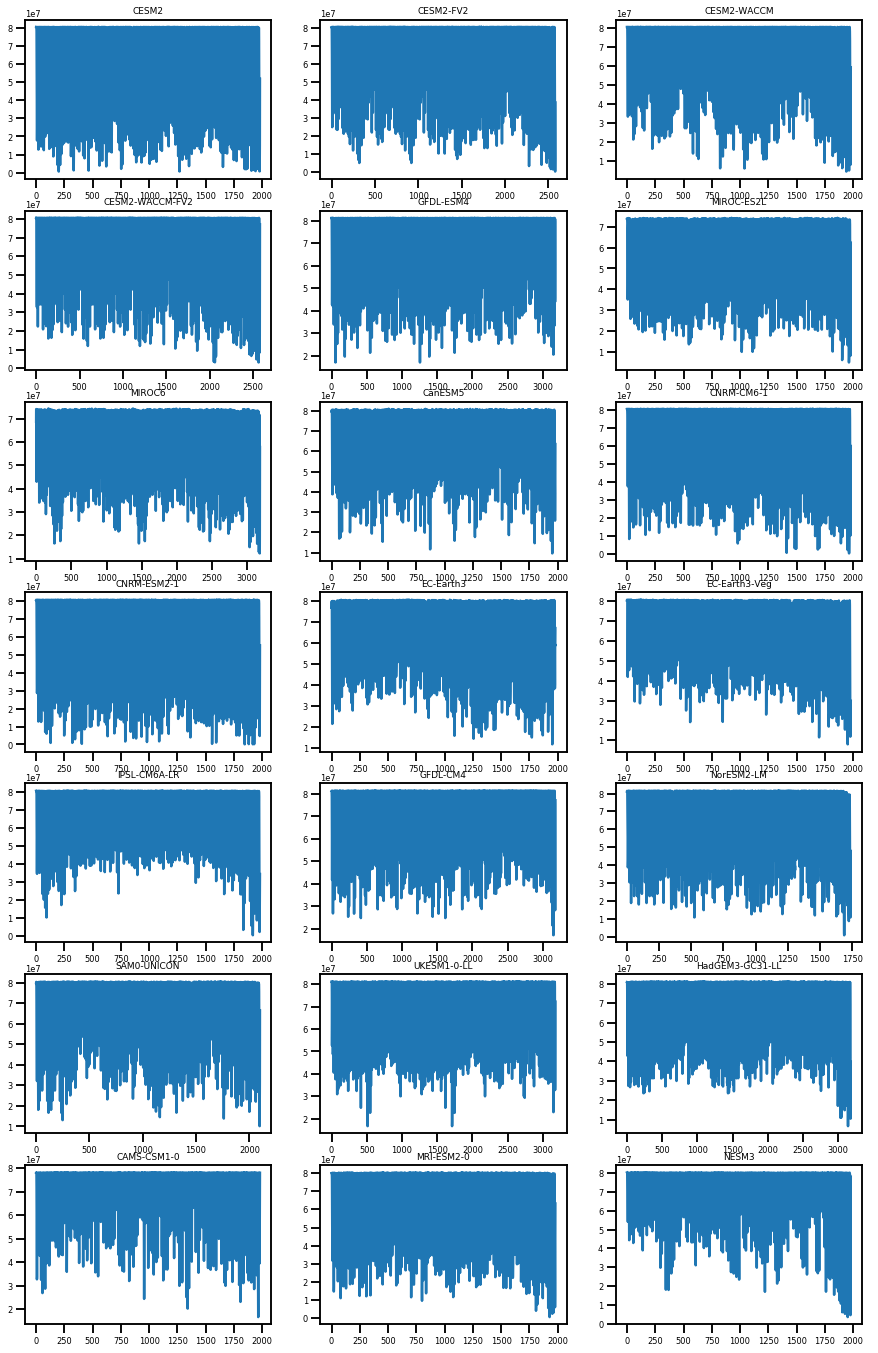

In [6]:
f, ax = plt.subplots(nrows=7,ncols=3)
f.set_size_inches(15,24)
ax = ax.reshape(-1)
sns.set_context("talk", font_scale=0.5, rc={"lines.linewidth": 2.5})

for (im,model) in enumerate(models):
    infile = glob.glob('../SIA_by_regions/regions_siconc_SImon_'+model+'_historical_*.nc')
    ds=xr.open_mfdataset(infile[0])
    ax[im].plot(ds.Region_Areas.isel(nregions=12).values)
    ax[im].set_title(model)